In [0]:
#Mount Drive
from google.colab import drive
drive.mount("/content/drive") 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#Extract Zip Files

from zipfile import ZipFile
file_name = "/content/drive/My Drive/Ham10000/Ham10000.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall("/Ham10000")
  print('Done')

Done


In [0]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

In [0]:
import os
import gc
from PIL import Image
import tensorflow

import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LeakyReLU
from keras.applications import VGG16

from sklearn.utils import check_random_state


sns.set()
np.random.seed(0);
tensorflow.random.set_seed(0)
check_random_state(0);

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
train_imgs, test_imgs = [], []
train_labels, test_labels = [], []

for img_path in os.listdir('/Ham10000/Ham10000/train_dir/Benign'):
    train_imgs.append('/Ham10000/Ham10000/train_dir/Benign/' + img_path)
    train_labels.append(0)
    
for img_path in os.listdir('/Ham10000/Ham10000/train_dir/Malignant'):
    train_imgs.append('/Ham10000/Ham10000/train_dir/Malignant/' + img_path)
    train_labels.append(1)
    
for img_path in os.listdir('/Ham10000/Ham10000/val_dir/Benign'):
    test_imgs.append('/Ham10000/Ham10000/val_dir/Benign/' + img_path)
    test_labels.append(0)
    
for img_path in os.listdir('/Ham10000/Ham10000/val_dir/Malignant'):
    test_imgs.append('/Ham10000/Ham10000/val_dir/Malignant/' + img_path)
    test_labels.append(1)
    
train_imgs, test_imgs = np.array(train_imgs), np.array(test_imgs)
train_labels, test_labels = np.array(train_labels), np.array(test_labels)
    
class_distribution = np.bincount(np.concatenate([train_labels, test_labels]))
    
print('Size of train set:', len(train_imgs))
print('Size of test set:', len(test_imgs))
print(class_distribution[0], 'benign labeled samples and', class_distribution[1], 'malignant')

Size of train set: 8912
Size of test set: 1103
8061 benign labeled samples and 1954 malignant


In [0]:
# Load the images to memory
xtrain, xtest = [], []
ytrain, ytest = train_labels, test_labels

for filename in train_imgs:
    xtrain.append(np.array(Image.open(filename)))
    
for filename in test_imgs:
    xtest.append(np.array(Image.open(filename)))
    
del train_imgs, test_imgs, train_labels, test_labels
xtrain, xtest = np.array(xtrain), np.array(xtest)

# Merge and split train and test set to have more train data
data = np.concatenate([xtrain, xtest])
labels = np.concatenate([ytrain, ytest])

# Spliting data to train, validation and test values
xtrain, xtest, ytrain, ytest = train_test_split(data, labels, test_size=.2, random_state=0)
xtra, xval, ytra, yval = train_test_split(xtrain, ytrain, test_size=.05, random_state=0, shuffle=False)

gc.collect()
print('Shape of the new train set:', xtra.shape)
print('Shape of the new test set:', xtest.shape)
print('Shape of the validation set:', xval.shape)

Shape of the new train set: (7611, 450, 600)
Shape of the new test set: (2003, 450, 600)
Shape of the validation set: (401, 450, 600)


In [0]:

data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

data_generator.fit(xtra)

In [0]:
# Normalizing values
xtra = xtra.astype('float32') / 255.
xtest = xtest.astype('float32') / 255.
xval = xval.astype('float32') / 255.

print('Training data shape:', xtra.shape)
print('Min value:', xtra.min())
print('Max value:', xtra.max())

In [0]:
# Build the model
model = Sequential()

model.add(VGG16(include_top=False, input_shape=(224, 224, 3,)))
model.add(Flatten())
model.add(Dense(32))
model.add(LeakyReLU(0.001))
model.add(Dense(16))
model.add(LeakyReLU(0.001))
model.add(Dense(1, activation='sigmoid'))
model.layers[0].trainable = False

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

58892288/58889256 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                802848    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_______________________________________________________

In [0]:

epochs = 50 
batch_size = 10
h = model.fit_generator(data_generator.flow(x_tra,y_tra, batch_size=batch_size),
                              epochs = epochs, validation_data = (xval, yval),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


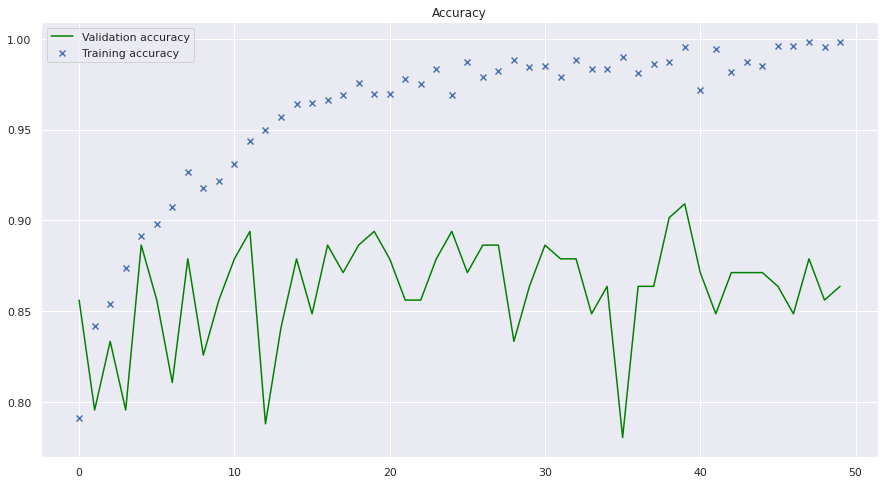

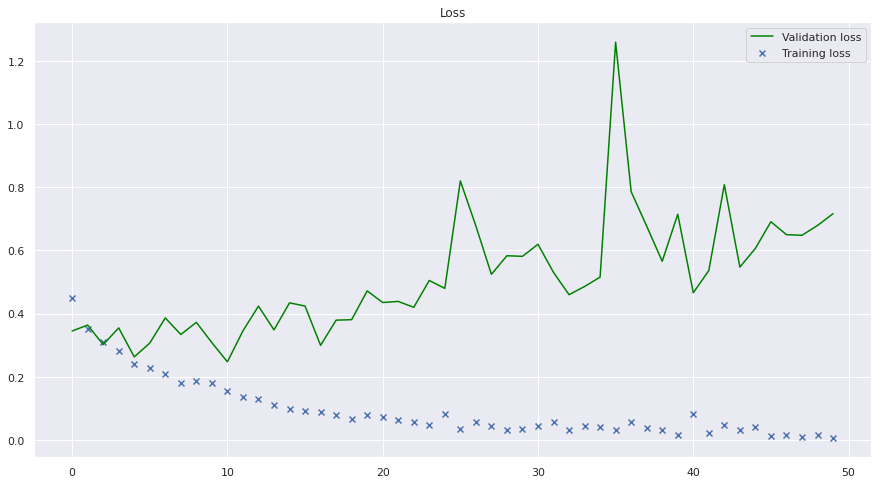

In [0]:
# Plotting accuracy history
plt.figure(figsize=(15, 8))
plt.scatter(range(N_EPOCHS), h.history['acc'], marker='x', label='Training accuracy');
plt.plot(range(N_EPOCHS), h.history['val_acc'], color='green', label='Validation accuracy');
plt.legend();
plt.title('Accuracy');

# Plotting loss history
plt.figure(figsize=(15, 8))
plt.scatter(range(N_EPOCHS), h.history['loss'], marker='x', label='Training loss');
plt.plot(range(N_EPOCHS), h.history['val_loss'], color='green', label='Validation loss');
plt.legend();
plt.title('Loss');

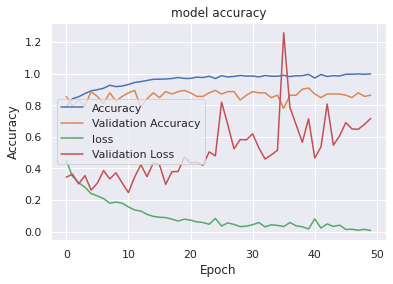

In [0]:
import matplotlib.pyplot as plt

plt.plot(h.history["acc"])
plt.plot(h.history['val_acc'])
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

In [0]:
print('Accuracy on test set:', model.evaluate(xtest, ytest)[1])
model.save('appDermis_vgg16.h5')

660/660 [==============================] - 2s 4ms/step
Accuracy on test set: 0.8590909242630005
